In [ ]:
%config Completer.use_jedi = False

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  """Entry point for launching an IPython kernel.


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sn
from tqdm.notebook import tqdm
 
from functools import partial
from collections import OrderedDict

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print(torch.__version__)

1.8.1+cu101



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


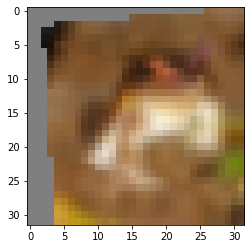

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     ]
)

if True:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        transforms.GaussianBlur(kernel_size=[3,3], sigma=(0.2, 1)),
        transforms.RandomAffine(degrees=[-20, 20], translate=[0.1, 0.1], scale=[0.9, 1.1], shear=[-20, 20]),
        ])
    
 
trainset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=32, shuffle=True, num_workers=2)
 
testset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(trainset[0][0])

In [ ]:
classes[trainset[0][1]]

'frog'

In [ ]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [ ]:
def test(net, dataloader, device='cuda:0'):
    net = net.to(device)
    conf_matrix = np.zeros((10, 10))
    for i, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = net(X)
            pred_cls = pred.argmax(1)
            for j in range(len(pred_cls)):
                conf_matrix[y[j]][pred_cls[j]] += 1
    return conf_matrix

In [ ]:
def train(net, dataloader, optimizer, loss_func, epochs=100, device='cuda:0', scheduler=None):
    n = len(trainloader.dataset)
    net.to(device)
    train_acc = np.zeros(epochs)
    test_acc = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in tqdm(range(epochs)):
        epoch_ok = 0
        
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            pred = net(X)
            loss = loss_func(pred, y)
            
            train_loss[epoch] += loss.item()
            pred_cls = pred.argmax(1)
            epoch_ok += sum(pred_cls == y)
            
            loss.backward()
            optimizer.step()
        
        if scheduler: scheduler.step()
        
        conf_matrix = test(net, testloader)    
        test_acc[epoch] = np.diag(conf_matrix).sum() / np.sum(conf_matrix)
        train_acc[epoch] = epoch_ok / n
        
        print(f'Epoch {epoch}: train loss: {train_loss[epoch]:.4f}, train acc: {train_acc[epoch]:.3f}, '
              f'test acc: {test_acc[epoch]}')
    
    return  train_acc, test_acc, train_loss, test_loss

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red, c_out : dict, res = False):
        super().__init__()

        self.resTF = res
        self.res = nn.Conv2d(c_in, c_out["1x1"]+c_out["3x3"]+c_out["5x5"]+c_out["max"], kernel_size=1)

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            nn.ReLU()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            nn.ReLU()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red, kernel_size=1),
            nn.BatchNorm2d(c_red),
            nn.ReLU(),
            nn.Conv2d(c_red, c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            nn.ReLU()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            nn.ReLU()
        )


    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)

        if self.resTF:
            residal = self.res(x)
            x_out += residal
        
        return x_out

class ResBlockSimpleR(nn.Module):
    def __init__(self, n_channels, n_red):
        super().__init__()
        self.module = nn.Sequential(
                    nn.Conv2d(n_channels, n_red, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(n_red),
                    nn.Conv2d(n_red, n_channels, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.BatchNorm2d(n_channels),
                )
 
    def forward(self, inputs):
        return self.module(inputs) + inputs

class IcepNet01(nn.Module):
    def __init__(self, classes=10, simpnet_name='IncepNet02'):
        super(IcepNet01, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
 
        self.inception_net = self._make_layers()
 
        self.gap = nn.MaxPool2d(kernel_size=(32, 32))
 
        self.linear = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 10),
            nn.ReLU()
        )
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception_net(x)
        x = self.gap(x)
        x = x.squeeze()
        # mlp block
        x = self.linear(x)
        return x
 
    def _make_layers(self):
 
        model = nn.Sequential(
            nn.ReLU(),
            nn.BatchNorm2d(16),
            ResBlockSimpleR(16,16),
            ResBlockSimpleR(16,16),
            InceptionBlock(c_in=16, c_red=16, c_out={"1x1":8, "3x3":8, "5x5":8, "max":8}),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            ResBlockSimpleR(32,32),
            ResBlockSimpleR(32,32),
            InceptionBlock(c_in=32, c_red=32, c_out={"1x1":16, "3x3":16, "5x5":16, "max":16}),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlockSimpleR(64,64),
            ResBlockSimpleR(64,64),
            InceptionBlock(c_in=64, c_red=64, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlockSimpleR(128,128),
            ResBlockSimpleR(128,128),
            InceptionBlock(c_in=128, c_red=128, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlockSimpleR(128,128),
            ResBlockSimpleR(128,128),
            InceptionBlock(c_in=128, c_red=128, c_out={"1x1":32, "3x3":32, "5x5":32, "max":32}),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
 
        for m in model.modules():
          if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
 
        return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
loss_func = nn.CrossEntropyLoss()
net = IcepNet01().to(device)
sgd = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(sgd, step_size=10, gamma=0.5, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-02.


In [ ]:
train_acc, test_acc, train_loss, test_loss = train(net, trainloader, sgd, loss_func, 20)

Epoch 0: train loss: 421.0696, train acc: 0.911, test acc: 0.8307
Epoch 1: train loss: 417.2503, train acc: 0.911, test acc: 0.8311
Epoch 2: train loss: 410.5952, train acc: 0.914, test acc: 0.8301
Epoch 3: train loss: 407.5097, train acc: 0.915, test acc: 0.8397
Epoch 4: train loss: 406.2051, train acc: 0.913, test acc: 0.8401
Epoch 5: train loss: 393.3257, train acc: 0.917, test acc: 0.8269
Epoch 6: train loss: 395.6871, train acc: 0.916, test acc: 0.8428
Epoch 7: train loss: 390.4066, train acc: 0.918, test acc: 0.8347
Epoch 8: train loss: 386.5334, train acc: 0.918, test acc: 0.8416
Epoch 9: train loss: 379.3820, train acc: 0.919, test acc: 0.8294
Epoch 10: train loss: 378.5038, train acc: 0.920, test acc: 0.8345
Epoch 11: train loss: 376.4863, train acc: 0.919, test acc: 0.8293
Epoch 12: train loss: 373.6570, train acc: 0.919, test acc: 0.8344
Epoch 13: train loss: 368.2400, train acc: 0.922, test acc: 0.8401
Epoch 14: train loss: 363.8404, train acc: 0.923, test acc: 0.837
Epoch 

In [ ]:
import pandas as pd
dataset = pd.DataFrame({'train_acc': train_acc, 
                        'test_acc': test_acc,
                        'train_loss': train_loss, 
                        'test_loss': test_loss})
dataset.to_csv('incepionxRESNET_dense_02.csv')

# Specify a path
PATH = "Inception_xRESNET_dense_02.pt"

# Save
torch.save(net, PATH)

NameError: ignored

In [ ]:
from google.colab import files
files.download('incepionxRESNET_dense_02.csv')
files.download('incepionxRESNET_dense_02.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: ignored

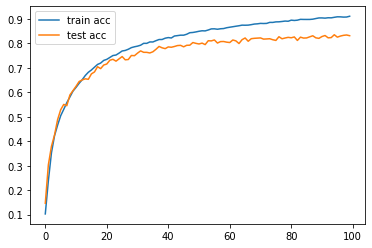

In [ ]:
plt.plot(train_acc,label='train acc')
plt.plot(test_acc,label='test acc')
plt.legend()
plt.show()

In [ ]:
model = IcepNet01()

model.load_state_dict(torch.load('Inception_xRESNET_dense.pt'))
model.eval()

AttributeError: ignored

- lr scheduler,
- 